<br>

아래 진행되는 실습코드는 [캐글 노트북](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays) 을 기반으로 작성되었습니다.

<br>

<br>

## Set-up

<br>

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

<br>

### !!! 원본 데이터 사이즈를 너무 많이 줄이면 이미지가 뭉개져서 예측률 개선이 어려울 수 있습니다 !!! <br><br>

원본 데이터 픽섹 ( 1200 대 , 1400 대 )

<br>

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 64

# X-RAY 이미지 사이즈 변수
# 모델학습 n차시 : [180, 180] -> [360, 360] -> [720, 720]
# 학습결과 n차시 :  acc 0.77    acc 0.80         메모리 터짐
IMAGE_SIZE = [360, 360]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/ssac29/aiffel


<br>

## 데이터 준비

<br>

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


<br>

### 데이터셋 조정 <br><br>

train : 5216개 <br>
test : 624개 <br>
val : 16개 <br><br>

Train, Test, Validation 데이터셋의 개수 비는 89%, 10.7%, 0.3% <br>
validation 개수가 부족하여 train 에서 validation 에 쓸 데이터를 더 가져오기 <br>

train과 val에 있는 데이터를 하나로 모아 train : val 를 80:20으로 분할

<br>

In [4]:
# Train / Validation 데이터셋 재분할
# Scikit-Learn 의 train_test_split() 메서드 사용

filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
# 위에서 불러온 train 데이터셋에 val 데이터셋 추가 (extend)
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, validation 데이터셋 분할
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


<br>

#### 데이터셋 조정 결과 <br><br>

train : 4185개 <br>
test : 624개 <br>
val : 1047개

<br>

In [5]:
# Train 데이터셋 안의 'NORMAL' 이미지 수와 'PNEUMONIA' 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1056
Pneumonia images count in training set: 3129


<br>

#### 데이터셋 balance <br><br>

CNN 모델의 경우 데이터가 클래스별 balance 가 좋을 수록 학습을 잘 합니다. <br>
( 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정 ) <br><br>

test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 <br>
imbalance한 데이터 셋이어도 문제 없습니다.

<br>

<br>

### tf.data 인스턴스 생성 <br><br>

- __tf.data.Dataset.from_tensor_slices()__ <br>
tf.data 는 tensorflow 에서 학습시, 배치처리 작업을 효울적으로 할 수 있도록 도와줍니다.

<br>

In [6]:
# tf.data 인스턴스 생성

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train / Validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨(label) 이름 확인

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


<br>

### 라벨(label) 데이터 생성 <br><br>

현재 이미지에는 라벨 데이터가 따로 없습니다. <br>
제목의 'NORMAL', 'PNEUMONIA' 로 라벨 데이터를 만들어 주는 함수를 작성합니다.

<br>

In [9]:
# 라벨(label) 데이터 생성하는 함수 작성

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴
    return parts[-2] == "PNEUMONIA"

<br>

## 데이터 전처리

<br>

<br>

### 이미지 사이즈 조정 (통일) <br><br>

현실상황에서 이미지 데이터는 사이즈가 제각각인 경우가 많습니다. <br>
이미지 사이즈를 줄여서 이를 해결해 봅시다. <br>
- 이미지의 사이즈를 통일하기 위함 <br>
- GPU 메모리를 더욱 효율적으로 사용하기 위함 <br><br><br>



#### decode_img 함수와 process_path 함수를 생성 <br><br>

- __decode_img()__ 함수 <br>
이미지의 데이터 타입을 float으로 변경하고, 이미지 사이즈를 변경합니다. <br>
- __process_path()__ 함수 <br>
decode_img() 로 이미지 사이즈를 조정하고 get_label() 으로 라벨 값을 가져옵니다.

<br>

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 변경
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 변경
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    # 라벨(label)값 가져오기
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    # 이미지 조정
    img = decode_img(img)
    return img, label

<br>

### Train / Validation 데이터셋 이미지 조정

위에서 만든 함수를 이용해 train 데이터 셋과 validation 데이터 셋 이미지 조정해줍니다. <br>
- num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 <br>
더욱 빠르게 데이터를 처리해줍니다.

<br>

In [11]:
# Train / Validation 데이터셋 이미지 조정, 라벨 추가

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이즈 확인
# 라벨(label) 확인

# train_ds.take(1) : 하나의 데이터만 가져와서 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (360, 360, 3)
Label:  True


In [13]:
# Test 데이터셋 이미지 조정, 라벨 추가

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


<br>

### 효율적 학습을 위한 Train 데이터 변환 <br><br>


#### 학습데이터에 tf.data 파이프라인 적용 <br>
prepare_for_training() 함수를 작성하여 <br>
학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다. <br><br>


#### tf.data 파이프라인 <br>
Tensorflow에서는 tf.data 파이프라인을 사용해서 <br>
학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. <br><br>

- shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택 <br><br>

- repeat() : epoch를 진행하면서 여러번 데이터셋을 불러올 때, repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용 가능 <br>
ex. 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다. <br><br>

- batch() : BATCH_SIZE에서 정한 만큼의 배치로 제공
ex. 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다. <br><br>

- prefetch() : 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

<br>

In [14]:
# 학습 데이터를 효율적으로 사용할 수 있도록 변환해주는 함수 작성

def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

<br>

### 데이터 시각화 <br><br>

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출 <br>
추출된 배치를 image와 label 데이터 셋으로 분리 <br>
show_batch()함수를 이용해서 결과 사진을 시각화하여 확인

<br>

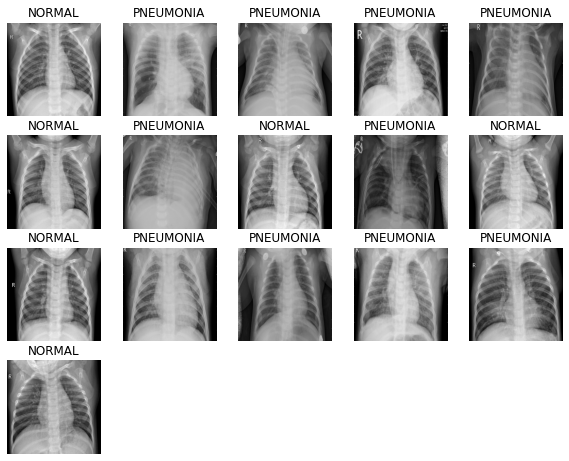

In [15]:
# 학습 데이터셋의 batch 하나 불러와서, label 별 image 확인

image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

<br>

## CNN 모델링 <br><br>

[CNN, Convolutional Neural Network 요약](http://taewan.kim/post/cnn/)

<br>

<br>

### Convolution block 생성 <br>

구성
- Convolution
- Convolution
- Batch Normalization ( Gradient vanishing, Gradient Exploding을 해결 )
- Max Pooling

<br>

In [16]:
# Convolution block 생성

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

<br>

### Dense block 생성

<br>

In [17]:
# Dense block 생성

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

<br>

### Regularization : Batch-Normalization 과 Droupout <br><br>

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. <br>
방금 만들어진 모델에는 __Batch Normalization__ 과 __Dropout__ 이라는 두가지 regularization 기법이 동시에 사용되고 있습니다. <br><br>

- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. <br>
대표적으로 아래와 같은 논문의 사례를 들 수 있습니다. <br><br>
[Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf) <br>
위 논문에서는 variance shift를 억제하는 Batch Normalization과 <br>
이를 유발시키는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다. <br><br>

- 그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. <br>
예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있습니다. <br>
아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다. <br><br>
[Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf) <br><br>


이번 실습에서는 Batch-Nomalization 과 Dropout 두가지를 함께 사용하는 이 모델이 <br>
성능향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

<br>

In [18]:
# CNN 모델 구성
# 위에서 구성한 conv_block 과 dense_blcok 이 들어가 있습니다

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

<br>

## 데이터 Imbalance 처리 <br><br>

" 한 라벨이 너무 많은 경우를 __imbalance__ 하다고 합니다. " <br><br>

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었습니다. <br>
데이터를 학습 할 때 imbalance 한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다. <br><br><br>


### Weight balancing 테크닉 <br><br>

Weight balancing 은 imbalance 문제를 해결하는데 사용됩니다. <br><br>

- training set 의 각 데이터에서 loss 를 계산할 때, <br>
특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. <br><br>

- Keras 는 model.fit()을 호출할 때, <br>
파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. <br><br>
참고. <br>
[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414) <br><br><br>


아래 코드에서 <br>
weight_for_0은 'Normal' 이미지에 사용할 weight를, <br>
weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. <br>
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

<br>

In [25]:
# 데이터 Imbalance 확인

print('NORMAL 데이터의 개수 : ', COUNT_NORMAL)
print('PNEUMONIA 데이터의 개수 : ', COUNT_PNEUMONIA)

NORMAL 데이터의 개수 :  1056
PNEUMONIA 데이터의 개수 :  3129


In [19]:
# model.fit() 의 파라미터 class_weight 값 세팅
# 클래스별 가중치 세팅

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.98
Weight for class 1: 0.67


<br>

## 모델 훈련 <br><br>

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU 를 선택합니다. <br>
모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다. <br><br>

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. <br>
optimizer로 'adam'을 사용합니다. <br><br>

성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

<br>

In [20]:
# GPU 설정
with tf.device('/GPU:0'):
    model = build_model()

# 매트릭 설정
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
# 모델 컴파일
# optimizer, loss 결정
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

<br>

## 모델 학습

<br>

In [21]:
# 모델 학습 (fit)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 67s 1s/step - loss: 0.3220 - accuracy: 0.8394 - precision: 0.9743 - recall: 0.8062 - val_loss: 0.5971 - val_accuracy: 0.7168 - val_precision: 0.7168 - val_recall: 1.0000
Epoch 2/25
65/65 [==============================] - 61s 945ms/step - loss: 0.1620 - accuracy: 0.9387 - precision: 0.9860 - recall: 0.9312 - val_loss: 0.8521 - val_accuracy: 0.7197 - val_precision: 0.7197 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 57s 877ms/step - loss: 0.1187 - accuracy: 0.9594 - precision: 0.9907 - recall: 0.9546 - val_loss: 1.0328 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 67s 1s/step - loss: 0.1058 - accuracy: 0.9635 - precision: 0.9865 - recall: 0.9644 - val_loss: 1.1968 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 62s 950ms/step - loss: 0.0975 - accuracy: 0.9666 - pre

<br>

## 결과 확인 <br><br>

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

<br>

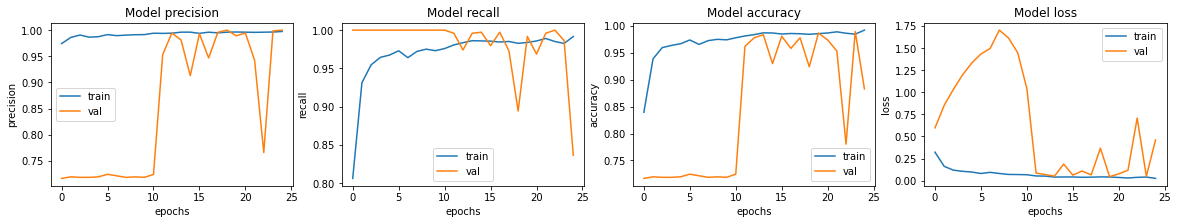

In [22]:
# metrics 으로 결과 평가

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

<br>

## 모델 평가 <br><br>

테스트 데이터로 모델 평가를 해보겠습니다. <br>

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 해보겠습니다.

<br>

In [23]:
# 테스트 데이터로 모델 평가

loss, acc, prec, rec = model.evaluate(test_ds)

10/10 [==============================] - 32s 3s/step - loss: 0.4820 - accuracy: 0.8846 - precision: 0.8822 - recall: 0.9410


<br>

이제 여러분들도 페렴 진단에 있어서 약 80% 정도는 맞출 수 있게 되었습니다. <br>
의사분들이 90% 이상이시니 거의 비슷한 실력이라기에는 다소 모자라는 느낌은 있지만 의료 보조 용도로는 어느정도 쓸만한 모델이라고는 할수 있겠습니다.

<br>

<br>

## 성능 개선을 위한 방법들 <br><br>

성능을 좀더 개선해볼 수 있는 방법은 없을까요? <br>
오늘 우리가 다룬 폐렴 데이터를 기반으로 한 연구도 많이 찾아볼 수 있습니다. <br><br>


### Data Augmentation <br><br>

의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다. 이런 문제를 해결하기 위해 Data augmentation 방법을 많이 시도합니다. <br>
Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많습니다. 그래서 의료분야에서는 기본적인 Data augmentation 방법들을 많이 사용합니다. 이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용합니다. 특히 장기의 크기는 사람마다 거의 바뀌지 않습니다. 이런 특성을 이용한 방법이 노이즈 추가 방법입니다. <br><br>


### GAN 을 활용한 Augmentation <br><br>

전통적인 Data augmentation 방법 이외에도 GAN 을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고하시면 좋을 것 같습니다.

<br>

<br>

### Augmentation 유의 점 <br><br>

의료영상의 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. <br>
특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수 있습니다. <br>
그래서 augmentation 도입은 신중해야 합니다. <br><br>

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

<br>

In [24]:
# 좌우반전 data augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)